## Contents
1. Training a Mini-GPT from Scratch

	1) Data Preprocess

	2) Building the Causal Language Model
2. BERT

	1) What is BERT? - Masked Language Modeling, Next Sentence Prediction

	2) Sentiment Analysis with BERT

	3) Sentiment Classification with BERT


# Training a Mini-GPT from Scratch

There are two types of language modeling - causal and masked. In this section we'll be building a mini-GPT from scratch (causal language modeling). In the section below, we'll work on masked language modeling with BERT. Causal language models are frequently used for text generation, such as code generation, summarization, autocompletion tasks.

In [1]:
!pip3 install datasets
!pip3 install easydict
!pip3 install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [ ]:
from datasets import load_dataset
from typing import List
import torch

### 1. Data Preprocess
We'll use the answer texts of the ELI5 dataset (Long-form Question Answering) to generate long form text.

In [ ]:
# load train, valid, test datasets
eli5_train = load_dataset("eli5", split="train_asks[:50000]")
eli5_valid = load_dataset("eli5", split="validation_asks[:2000]")
eli5_test = load_dataset("eli5", split="test_asks[:2000]")

Downloading:   0%|          | 0.00/3.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/576M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/286M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.65M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/18.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/36.2M [00:00<?, ?B/s]

In [ ]:
eli5 = {"train": eli5_train, "valid": eli5_valid, "test": eli5_test}
print(eli5["train"])
print(eli5["train"][1]["answers"]["text"])

Dataset({
    features: ['q_id', 'title', 'selftext', 'document', 'subreddit', 'answers', 'title_urls', 'selftext_urls', 'answers_urls'],
    num_rows: 50000
})
["While Freud was successful in bringing applied psychology into mainstream awareness and practice, equally we still have some throw-backs to his now-unsupported theories.\n\nOne of those is the intense focus on childhood experience and upbringing including as you said believing that because their parents did X they learnt Y.\n\nIn many respects from a practical point of view knowing the exact learning history of a harmful belief is irrelevant to learning a more helpful one. I would also argue that many people's claims of where their beliefs originated has more to do with their narration of themselves rather than accurate summary about their own cognition.\n\nHOWEVER a caveat - many people may find identifying a potential learning history such as 'my parents did X' may find this makes it easier to change said belief. Without su

In [ ]:
for key in eli5:
	eli5[key] = eli5[key].flatten() #flatten the nested keys

print(eli5["train"])
print(eli5['train'][1]["answers.text"])
print(len(eli5['train'][1]["answers.text"]))

Dataset({
    features: ['q_id', 'title', 'selftext', 'document', 'subreddit', 'answers.a_id', 'answers.text', 'answers.score', 'title_urls.url', 'selftext_urls.url', 'answers_urls.url'],
    num_rows: 50000
})
["While Freud was successful in bringing applied psychology into mainstream awareness and practice, equally we still have some throw-backs to his now-unsupported theories.\n\nOne of those is the intense focus on childhood experience and upbringing including as you said believing that because their parents did X they learnt Y.\n\nIn many respects from a practical point of view knowing the exact learning history of a harmful belief is irrelevant to learning a more helpful one. I would also argue that many people's claims of where their beliefs originated has more to do with their narration of themselves rather than accurate summary about their own cognition.\n\nHOWEVER a caveat - many people may find identifying a potential learning history such as 'my parents did X' may find this

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
##################TODO###################
# 1. For each data sample, join all the sentences and create a single sentence
# 2. tokenize the joined sentence
def preprocess_function(examples):
    return tokenizer([" ".join(x) for x in examples["answers.text"]])

(…)e.co/distilgpt2/resolve/main/config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

(…)ce.co/distilgpt2/resolve/main/vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

(…)ce.co/distilgpt2/resolve/main/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)o/distilgpt2/resolve/main/tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
tokenized_eli5 = dict()

# apply map function to each eli5[key] element with multiple processes.
for key in eli5:
	tokenized_eli5[key] = eli5[key].map(
		preprocess_function,
		batched=True, # operate on batches
		num_proc=4,
		remove_columns=eli5["train"].column_names,
	)

Map (num_proc=4):   0%|          | 0/50000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1290 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1257 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2008 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1064 > 1024). Running this sequence through the model will result in indexing errors


Map (num_proc=4):   0%|          | 0/2000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1499 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1363 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1566 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2022 > 1024). Running this sequence through the model will result in indexing errors


Map (num_proc=4):   0%|          | 0/2000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2136 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1051 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1027 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1106 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
print(tokenized_eli5["train"])
print(tokenized_eli5["train"][0]['input_ids'])

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 50000
})
[40, 750, 617, 2267, 355, 257, 3830, 805, 13, 1881, 10041, 2836, 685, 6604, 82, 340, 4909, 16151, 62, 21886, 62, 16, 62, 8, 5867, 11296, 286, 3602, 2704, 1071, 12769, 11, 475, 314, 460, 470, 1283, 284, 1064, 597, 6374, 5030, 393, 12448, 2524, 326, 30220, 689, 326, 13, 3602, 2704, 1071, 12769, 318, 257, 12972, 40978, 3882, 11, 3519, 284, 257, 36466, 4635, 416, 27856, 415, 4411, 5700, 1444, 12972, 40978, 6582, 13, 383, 10193, 468, 685, 1416, 415, 1321, 319, 12972, 260, 26110, 2340, 16151, 62, 21886, 62, 15, 62, 828, 475, 262, 11529, 2331, 284, 307, 326, 1877, 16376, 389, 4632, 23585, 13]


In [ ]:
block_size = 128

def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]]) # total length of input_ids
    if total_length >= (block_size-2):
        total_length = (total_length // (block_size-2)) * (block_size-2)
    # Split by chunks of block_size, and add bos/eos token on each end
    result = {
        k: [[tokenizer.bos_token_id]+t[i : i + block_size-2]+[tokenizer.eos_token_id] for i in range(0, total_length, block_size-2)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_dataset = dict()
for key in tokenized_eli5:
	lm_dataset[key] = tokenized_eli5[key].map(group_texts, batched=True, num_proc=4)

print(lm_dataset)
print(lm_dataset['train'][4]['input_ids'])
print(len(lm_dataset['train'][3]['input_ids']))

Map (num_proc=4):   0%|          | 0/50000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2000 [00:00<?, ? examples/s]

{'train': Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 133174
}), 'valid': Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 13077
}), 'test': Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 16532
})}
[50256, 11, 407, 1919, 6631, 13, 1318, 318, 257, 1256, 286, 17004, 284, 262, 2126, 286, 4547, 1223, 284, 1487, 340, 13, 2102, 867, 7612, 286, 508, 356, 389, 290, 703, 356, 481, 9427, 351, 262, 995, 4745, 319, 262, 717, 1248, 1933, 286, 1204, 290, 262, 2776, 351, 262, 4165, 1337, 30157, 286, 262, 1048, 13, 220, 770, 318, 477, 878, 530, 460, 2740, 393, 1296, 17755, 9846, 13, 220, 632, 318, 2408, 284, 366, 4625, 1481, 1, 1223, 326, 318, 257, 1767, 393, 7016, 4088, 326, 468, 645, 1598, 750, 12009, 7515, 13, 220, 220, 198, 198, 1858, 318, 6088, 286, 2370, 284, 1950, 326, 345, 460, 4512, 3511, 374, 15208, 284, 6687, 10825, 290, 7666, 13, 1318, 318, 635, 617, 3872, 284, 262, 2126, 50256]
128


In [ ]:
eli5_dataset = dict()
for key in lm_dataset:
	result = []
	for i in lm_dataset[key]:
		result.append(i['input_ids']) # create a single nested list of all input_ids
	eli5_dataset[key] = torch.tensor(result).to(torch.int64) # modify to torch.tensor

print(eli5_dataset["train"])
print(eli5_dataset["train"].shape)

tensor([[50256,    40,   750,  ...,   423,   617, 50256],
        [50256,  3714,    12,  ...,  1395,     6, 50256],
        [50256,   743,  1064,  ...,   810,   257, 50256],
        ...,
        [50256,   423,  1194,  ...,   826,   835, 50256],
        [50256,    13,   887,  ...,   262,  2866, 50256],
        [50256,   286,   262,  ...,  2412,   319, 50256]])
torch.Size([133174, 128])


In [ ]:
print(tokenizer.decode(eli5_dataset["train"][0]))

<|endoftext|>I did some research as a layman. One forum user [claims it contains](_URL_1_) 300mg of Transfluthrin, but I can't seem to find any SC Johnson or Raid site that corroborates that. Transfluthrin is a pyrethroid, related to a pesticide produced by Chrysanthemums called pyrethrum. The EPA has [scant information on pyrethroids](_URL_0_), but the consensus seems to be that low doses are mostly harmless.While Freud was successful in bringing applied psychology into mainstream awareness and practice, equally we still have some<|endoftext|>


In [ ]:
print(tokenizer.bos_token_id)
print(tokenizer.decode(tokenizer.bos_token_id))
print(tokenizer.decode(tokenizer.eos_token_id))

50256
<|endoftext|>
<|endoftext|>


### 2. Building a Causal Language Model

Text generation is best addressed with auto-regressive or causal language models such as GPT. GPT is a Transformer-based decoder-only model without an encoder. Thus each decoder layer of GPT-based models consists of masked self-attention and a feed network, without the encoder-decoder attention.

The structure of a decoder layer is shown below:
<div>
<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-27_at_12.41.44_PM.png" width=1000)/>
</div>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We will be building the Mini-GPT model upon our Transformer model implemented last week. We'll reuse the MultiHeadAttention, PositionWiseFeedForward, SinusoidalPositionalEmbedding, Decoder modules. We need to modify the DecoderLayer so that there is no enc-dec attention.
#### 1) Basic Building Blocks
##### a. Multi-Head Attention
__Multi-head attention:__
<img src="http://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png" width=650)/>
* Equation:
$$\begin{align} \text{MultiHead}(Q, K, V) &= \text{Concat}(head_1, ...., head_h) W^O \\
\text{where head}_i &= \text{Attention} \left( QW^Q_i, K W^K_i, VW^v_i \right)
\end{align}$$

In [ ]:
class MultiHeadAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(
        self,
        emb_dim,
        num_heads,
        dropout=0.0,
        bias=False,
        encoder_decoder_attention=False,  # otherwise self_attention
        causal = False
    ):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = emb_dim // num_heads
        assert self.head_dim * num_heads == self.emb_dim, "emb_dim must be divisible by num_heads"

        self.encoder_decoder_attention = encoder_decoder_attention
        self.causal = causal
        self.q_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.k_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.v_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=bias)


    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (
            self.num_heads,
            self.head_dim,
        )
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)
        # This is equivalent to
        # return x.transpose(1,2)


    def scaled_dot_product(self,
                           query: torch.Tensor,
                           key: torch.Tensor,
                           value: torch.Tensor,
                           attention_mask: torch.BoolTensor):

        attn_weights = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(self.emb_dim) # QK^T/sqrt(d)

        if attention_mask is not None:
            attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(1), float("-inf"))

        attn_weights = F.softmax(attn_weights, dim=-1)  # softmax(QK^T/sqrt(d))
        attn_probs = F.dropout(attn_weights, p=self.dropout, training=self.training)
        attn_output = torch.matmul(attn_probs, value) # softmax(QK^T/sqrt(d))V

        return attn_output, attn_probs


    def MultiHead_scaled_dot_product(self,
                       query: torch.Tensor,
                       key: torch.Tensor,
                       value: torch.Tensor,
                       attention_mask: torch.BoolTensor):

        attn_weights = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(self.head_dim) # QK^T/sqrt(d)

        # Attention mask
        if attention_mask is not None:
            if self.causal:
              # (seq_len x seq_len)
                attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(0).unsqueeze(1), float("-inf"))
            else:
              # (batch_size x seq_len)
                attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(1).unsqueeze(2), float("-inf"))


        attn_weights = F.softmax(attn_weights, dim=-1)  # softmax(QK^T/sqrt(d))
        attn_probs = F.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.matmul(attn_probs, value) # softmax(QK^T/sqrt(d))V
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        concat_attn_output_shape = attn_output.size()[:-2] + (self.emb_dim,)
        attn_output = attn_output.view(*concat_attn_output_shape)
        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights


    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        attention_mask: torch.Tensor = None,
        ):

        q = self.q_proj(query)
        # Enc-Dec attention
        if self.encoder_decoder_attention:
            k = self.k_proj(key)
            v = self.v_proj(key)
        # Self attention
        else:
            k = self.k_proj(query)
            v = self.v_proj(query)

        q = self.transpose_for_scores(q)
        k = self.transpose_for_scores(k)
        v = self.transpose_for_scores(v)

        attn_output, attn_weights = self.MultiHead_scaled_dot_product(q,k,v,attention_mask)
        return attn_output, attn_weights


#### b. Position-wise feed-forward network
<a id='1b'></a>
In this section, we will implement position-wise feed forward network

$$\text{FFN}(x) = \max \left(0, x W_1 + b_1 \right) W_2 + b_2$$

In [ ]:
class PositionWiseFeedForward(nn.Module):

    def __init__(self, emb_dim: int, d_ff: int, dropout: float = 0.1):
        super(PositionWiseFeedForward, self).__init__()

        self.activation = nn.ReLU()
        self.w_1 = nn.Linear(emb_dim, d_ff)
        self.w_2 = nn.Linear(d_ff, emb_dim)
        self.dropout = dropout

    def forward(self, x):
        residual = x
        x = self.activation(self.w_1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.w_2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x + residual # residual connection for preventing gradient vanishing

#### c. Sinusoidal Positional Encoding
<a id='1c'></a>
In this section, we will implement sinusoidal positional encoding

$$\begin{align}
PE(pos, 2i) &= \sin \left( pos / 10000^{2i / d_{model}} \right)  \\
PE(pos, 2i+1) &= \cos \left( pos / 10000^{2i / d_{model}} \right)  
\end{align}$$

In [ ]:
import numpy as np

# Since Transformer contains no recurrence and no convolution,
# in order for the model to make use of the order of the sequence,
# we must inject some information about the relative or absolute position of the tokens in the sequence.
# To this end, we add “positional encodings” to the input embeddings at the bottoms of the encoder and decoder stacks.
# There are many choices of positional encodings, learned and fixed

class SinusoidalPositionalEmbedding(nn.Embedding):

    def __init__(self, num_positions, embedding_dim, padding_idx=None):
        super().__init__(num_positions, embedding_dim) # torch.nn.Embedding(num_embeddings, embedding_dim)
        self.weight = self._init_weight(self.weight) # self.weight => nn.Embedding(num_positions, embedding_dim).weight

    @staticmethod
    def _init_weight(out: nn.Parameter):
        n_pos, embed_dim = out.shape
        pe = nn.Parameter(torch.zeros(out.shape))
        for pos in range(n_pos):
            for i in range(0, embed_dim, 2):
                pe[pos, i].data.copy_( torch.tensor( np.sin(pos / (10000 ** ( i / embed_dim)))) )
                pe[pos, i + 1].data.copy_( torch.tensor( np.cos(pos / (10000 ** ((i + 1) / embed_dim)))) )
        pe.detach_()

        return pe

    @torch.no_grad()
    def forward(self, input_ids):
      bsz, seq_len = input_ids.shape[:2]
      positions = torch.arange(seq_len, dtype=torch.long, device=self.weight.device)
      return super().forward(positions)


#### 2) Transformer Decoder
##### a. Decoder Layer
In this section, we will build a Transformer Decoder layer without encoder-decoder attention.
<div>
<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-27_at_12.41.44_PM.png" width=1000)/>
</div>

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim
        self.ffn_dim = config.ffn_dim
        self.self_attn = MultiHeadAttention(
            emb_dim=self.emb_dim,
            num_heads=config.attention_heads,
            dropout=config.attention_dropout,
            causal=True,
        )
        self.dropout = config.dropout
        self.self_attn_layer_norm = nn.LayerNorm(self.emb_dim)
        self.PositionWiseFeedForward = PositionWiseFeedForward(self.emb_dim, self.ffn_dim, config.dropout)
        self.final_layer_norm = nn.LayerNorm(self.emb_dim)


    def forward( # we only need the self-attention and fully connected layers
        self,
        x,
        causal_mask=None,
    ):
        residual = x
        # Self Attention
        x, self_attn_weights = self.self_attn(
            query=x,
            key=x, # adds keys to layer state
            attention_mask=causal_mask,
        )
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = residual + x
        x = self.self_attn_layer_norm(x)

        # Fully Connected
        x = self.PositionWiseFeedForward(x)
        x = self.final_layer_norm(x)

        return (
            x,
            self_attn_weights,
        )

In [ ]:
class Decoder(nn.Module):

    def __init__(self, config, embed_tokens: nn.Embedding):
        super().__init__()
        self.dropout = config.dropout
        self.padding_idx = embed_tokens.padding_idx
        self.max_target_positions = config.max_position_embeddings
        self.embed_tokens = embed_tokens
        self.embed_positions = SinusoidalPositionalEmbedding(
            config.max_position_embeddings, config.emb_dim, self.padding_idx
        )
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.decoder_layers)])  # type: List[DecoderLayer]

    def forward(
        self,
        input_ids,
        decoder_causal_mask,
    ):

        # embed positions
        positions = self.embed_positions(input_ids)
        x = self.embed_tokens(input_ids)
        x += positions

        x = F.dropout(x, p=self.dropout, training=self.training)

        # decoder layers
        for idx, decoder_layer in enumerate(self.layers):
            x, layer_self_attn = decoder_layer(
                x,
                causal_mask=decoder_causal_mask,
            )

        return x # we don't need to return cross-attention-scores

#### 3) Mini-GPT Model
Let's build our mini-GPT model with the basic building blocks, and modified transformer decoder blocks.

In [ ]:
class GPT(nn.Module):
    def __init__(self, tokenizer, config):
        super().__init__()
        ##############TODO###############
        # create decoder embedding, decoder, prediction_head
        self.dec_embedding = nn.Embedding(len(tokenizer), config.emb_dim, padding_idx=tokenizer.pad_token_id)
        self.decoder = Decoder(config, self.dec_embedding)
        self.prediction_head = nn.Linear(config.emb_dim,len(tokenizer))
        ##################################

        self.init_weights()

    def generate_mask(self, trg): # we don't need the mask encoder attention part
        # Mask decoder attention for causality
        tmp = torch.ones(trg.size(1), trg.size(1), dtype=torch.bool)
        mask = torch.arange(tmp.size(-1))
        dec_attention_mask = tmp.masked_fill_(mask < (mask + 1).view(tmp.size(-1), 1), False).to(DEVICE)

        return dec_attention_mask

    def init_weights(self):
        for name, param in self.named_parameters():
            if param.requires_grad:
                if 'weight' in name:
                    nn.init.normal_(param.data, mean=0, std=0.01) # weight initialization by normal dist
                else:
                    nn.init.constant_(param.data, 0)

    def forward(
        self,
        trg,
    ):
        ##############TODO###############
        # 1. Generate decoder causal mask
        # 2. Put input in decoder layers
        # 3. Put decoder output through prediction head
        dec_causal_mask = self.generate_mask(trg)

        decoder_output = self.decoder( # decoder layers
            trg,
            decoder_causal_mask=dec_causal_mask,
        )
        decoder_output = self.prediction_head(decoder_output) # prediction head
        ################################

        return decoder_output

### 3. Training our Model

In [ ]:
torch.manual_seed(0)
import easydict
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

config = easydict.EasyDict({
    "emb_dim":128,
    "ffn_dim":512,
    "attention_heads":8,
    "attention_dropout":0.0,
    "dropout":0.2,
    "max_position_embeddings":128,
    "decoder_layers":6,
})

learning_rate = 5e-4
BATCH_SIZE = 64 # 128

model = GPT(tokenizer, config)
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
criterion = nn.CrossEntropyLoss()

best_valid_loss = float('inf')

In [ ]:
train_dataloader = DataLoader(eli5_dataset["train"], batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(eli5_dataset["valid"], batch_size=BATCH_SIZE)
test_iter = eli5_dataset["test"]

print(next(iter(train_dataloader)).shape)

torch.Size([128, 128])


In [ ]:
from tqdm import tqdm

def train_epoch(model, optimizer):
    model.train()
    losses = 0

    for tgt in tqdm(train_dataloader):
        tgt = tgt.to(DEVICE)

        logits = model(tgt)

        optimizer.zero_grad()

        tgt_out = tgt[:, 1:]
        logits = logits[:, :-1]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

        del tgt

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    with torch.no_grad():
        for tgt in valid_dataloader:
            tgt = tgt.to(DEVICE)

            logits = model(tgt)

            tgt_out = tgt[:, 1:]
            logits = logits[:, :-1]
            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            losses += loss.item()

            del tgt

    return losses / len(list(valid_dataloader))

In [ ]:
from timeit import default_timer as timer
NUM_EPOCHS = 5 # 50
best_loss = float("inf")

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    end_time = timer()
    val_loss = evaluate(model)
    # torch.save(model.state_dict(), f'model_{epoch}.pt')
    # if val_loss < best_loss:
    #     torch.save(model.state_dict(), f'best_model.pt')
    #     best_loss = val_loss
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


100%|██████████| 1041/1041 [02:24<00:00,  7.22it/s]


Epoch: 1, Train loss: 7.030, Val loss: 6.041, Epoch time = 144.519s


100%|██████████| 1041/1041 [02:23<00:00,  7.25it/s]


Epoch: 2, Train loss: 5.689, Val loss: 5.579, Epoch time = 143.956s


100%|██████████| 1041/1041 [02:25<00:00,  7.17it/s]


Epoch: 3, Train loss: 5.372, Val loss: 5.340, Epoch time = 145.383s


100%|██████████| 1041/1041 [02:25<00:00,  7.18it/s]


Epoch: 4, Train loss: 5.170, Val loss: 5.158, Epoch time = 145.290s


100%|██████████| 1041/1041 [02:25<00:00,  7.17it/s]


Epoch: 5, Train loss: 5.022, Val loss: 5.042, Epoch time = 145.421s


100%|██████████| 1041/1041 [02:24<00:00,  7.21it/s]


Epoch: 6, Train loss: 4.911, Val loss: 4.945, Epoch time = 144.676s


100%|██████████| 1041/1041 [02:24<00:00,  7.21it/s]


Epoch: 7, Train loss: 4.826, Val loss: 4.881, Epoch time = 144.668s


100%|██████████| 1041/1041 [02:25<00:00,  7.14it/s]


Epoch: 8, Train loss: 4.762, Val loss: 4.819, Epoch time = 146.024s


100%|██████████| 1041/1041 [02:25<00:00,  7.14it/s]


Epoch: 9, Train loss: 4.711, Val loss: 4.781, Epoch time = 146.055s


100%|██████████| 1041/1041 [02:24<00:00,  7.19it/s]


Epoch: 10, Train loss: 4.671, Val loss: 4.752, Epoch time = 145.032s


100%|██████████| 1041/1041 [02:24<00:00,  7.18it/s]


Epoch: 11, Train loss: 4.636, Val loss: 4.723, Epoch time = 145.220s


100%|██████████| 1041/1041 [02:24<00:00,  7.23it/s]


Epoch: 12, Train loss: 4.607, Val loss: 4.698, Epoch time = 144.303s


100%|██████████| 1041/1041 [02:23<00:00,  7.25it/s]


Epoch: 13, Train loss: 4.581, Val loss: 4.679, Epoch time = 143.914s


100%|██████████| 1041/1041 [02:24<00:00,  7.21it/s]


Epoch: 14, Train loss: 4.560, Val loss: 4.661, Epoch time = 144.736s


100%|██████████| 1041/1041 [02:24<00:00,  7.19it/s]


Epoch: 15, Train loss: 4.540, Val loss: 4.648, Epoch time = 145.090s


100%|██████████| 1041/1041 [02:24<00:00,  7.20it/s]


Epoch: 16, Train loss: 4.523, Val loss: 4.635, Epoch time = 144.782s


100%|██████████| 1041/1041 [02:25<00:00,  7.17it/s]


Epoch: 17, Train loss: 4.508, Val loss: 4.623, Epoch time = 145.587s


100%|██████████| 1041/1041 [02:24<00:00,  7.21it/s]


Epoch: 18, Train loss: 4.493, Val loss: 4.613, Epoch time = 144.732s


100%|██████████| 1041/1041 [02:24<00:00,  7.20it/s]


Epoch: 19, Train loss: 4.480, Val loss: 4.599, Epoch time = 144.790s


100%|██████████| 1041/1041 [02:24<00:00,  7.21it/s]


Epoch: 20, Train loss: 4.468, Val loss: 4.593, Epoch time = 144.685s


100%|██████████| 1041/1041 [02:23<00:00,  7.23it/s]


Epoch: 21, Train loss: 4.457, Val loss: 4.588, Epoch time = 144.237s


100%|██████████| 1041/1041 [02:25<00:00,  7.16it/s]


Epoch: 22, Train loss: 4.448, Val loss: 4.579, Epoch time = 145.613s


100%|██████████| 1041/1041 [02:24<00:00,  7.22it/s]


Epoch: 23, Train loss: 4.438, Val loss: 4.570, Epoch time = 144.448s


100%|██████████| 1041/1041 [02:24<00:00,  7.21it/s]


Epoch: 24, Train loss: 4.429, Val loss: 4.558, Epoch time = 144.584s


100%|██████████| 1041/1041 [02:24<00:00,  7.19it/s]


Epoch: 25, Train loss: 4.421, Val loss: 4.555, Epoch time = 145.069s


100%|██████████| 1041/1041 [02:24<00:00,  7.20it/s]


Epoch: 26, Train loss: 4.413, Val loss: 4.549, Epoch time = 144.879s


100%|██████████| 1041/1041 [02:24<00:00,  7.22it/s]


Epoch: 27, Train loss: 4.405, Val loss: 4.544, Epoch time = 144.504s


100%|██████████| 1041/1041 [02:24<00:00,  7.21it/s]


Epoch: 28, Train loss: 4.399, Val loss: 4.539, Epoch time = 144.644s


100%|██████████| 1041/1041 [02:24<00:00,  7.22it/s]


Epoch: 29, Train loss: 4.392, Val loss: 4.533, Epoch time = 144.414s


100%|██████████| 1041/1041 [02:23<00:00,  7.24it/s]


Epoch: 30, Train loss: 4.386, Val loss: 4.529, Epoch time = 144.039s


100%|██████████| 1041/1041 [02:24<00:00,  7.22it/s]


Epoch: 31, Train loss: 4.380, Val loss: 4.521, Epoch time = 144.514s


100%|██████████| 1041/1041 [02:24<00:00,  7.21it/s]


Epoch: 32, Train loss: 4.374, Val loss: 4.519, Epoch time = 144.653s


100%|██████████| 1041/1041 [02:25<00:00,  7.17it/s]


Epoch: 33, Train loss: 4.368, Val loss: 4.512, Epoch time = 145.505s


100%|██████████| 1041/1041 [02:24<00:00,  7.19it/s]


Epoch: 34, Train loss: 4.363, Val loss: 4.508, Epoch time = 145.124s


100%|██████████| 1041/1041 [02:24<00:00,  7.20it/s]


Epoch: 35, Train loss: 4.358, Val loss: 4.503, Epoch time = 144.826s


100%|██████████| 1041/1041 [02:24<00:00,  7.20it/s]


Epoch: 36, Train loss: 4.353, Val loss: 4.501, Epoch time = 144.829s


100%|██████████| 1041/1041 [02:24<00:00,  7.19it/s]


Epoch: 37, Train loss: 4.348, Val loss: 4.498, Epoch time = 145.014s


100%|██████████| 1041/1041 [02:24<00:00,  7.19it/s]


Epoch: 38, Train loss: 4.344, Val loss: 4.496, Epoch time = 144.983s


100%|██████████| 1041/1041 [02:23<00:00,  7.25it/s]


Epoch: 39, Train loss: 4.339, Val loss: 4.491, Epoch time = 143.845s


100%|██████████| 1041/1041 [02:22<00:00,  7.29it/s]


Epoch: 40, Train loss: 4.336, Val loss: 4.484, Epoch time = 143.076s


100%|██████████| 1041/1041 [02:22<00:00,  7.30it/s]


Epoch: 41, Train loss: 4.331, Val loss: 4.481, Epoch time = 142.797s


100%|██████████| 1041/1041 [02:24<00:00,  7.20it/s]


Epoch: 42, Train loss: 4.327, Val loss: 4.477, Epoch time = 144.924s


100%|██████████| 1041/1041 [02:22<00:00,  7.29it/s]


Epoch: 43, Train loss: 4.324, Val loss: 4.472, Epoch time = 143.072s


100%|██████████| 1041/1041 [02:24<00:00,  7.20it/s]


Epoch: 44, Train loss: 4.320, Val loss: 4.471, Epoch time = 144.847s


100%|██████████| 1041/1041 [02:24<00:00,  7.19it/s]


Epoch: 45, Train loss: 4.317, Val loss: 4.468, Epoch time = 145.100s


100%|██████████| 1041/1041 [02:24<00:00,  7.21it/s]


Epoch: 46, Train loss: 4.314, Val loss: 4.463, Epoch time = 144.721s


100%|██████████| 1041/1041 [02:22<00:00,  7.29it/s]


Epoch: 47, Train loss: 4.310, Val loss: 4.460, Epoch time = 143.061s


100%|██████████| 1041/1041 [02:22<00:00,  7.29it/s]


Epoch: 48, Train loss: 4.307, Val loss: 4.460, Epoch time = 143.071s


100%|██████████| 1041/1041 [02:23<00:00,  7.26it/s]


Epoch: 49, Train loss: 4.304, Val loss: 4.458, Epoch time = 143.645s


100%|██████████| 1041/1041 [02:24<00:00,  7.20it/s]


Epoch: 50, Train loss: 4.301, Val loss: 4.455, Epoch time = 144.943s


### 4. Greedy Decoding for Test Evaluation

In [ ]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, input, max_len):
    ##############TODO###############
    # 1. get model output
    # 2. find maximum value for each predicted token
    # 3. # get last prediction (our target word)
    # 4. concat greedy decoded token to sequence of words for next input
    #################################
    with torch.no_grad():
        for i in range(len(input), max_len):
            out = model(input)
            _, next_word = torch.max(out, dim=-1) # find maximum value for each predicted token
            next_word = next_word[:, -1] # get last prediction (our target)
            next_word = next_word.item()
            del out

            input = torch.cat([input,
                            torch.ones(1, 1).to(DEVICE).type_as(input.data).fill_(next_word)], dim=1)
            if next_word == tokenizer.eos_token_id:
                break
        return input

Let's print our greedy-decoded test generated results.

In [ ]:
import random

random.seed(1234)

In [ ]:
idx = random.choice(range(len(test_iter)))
test_data = torch.unsqueeze(test_iter[idx][:20], 0).to(DEVICE)
print(tokenizer.decode(test_data[0]))
print("Generating...")
generated = greedy_decode(model, test_data, 30)
print(tokenizer.decode(generated[0][1:]))

<|endoftext|> psychiatric illness? Dr Picciotto, thank you for your time. I am wondering if you
Generating...
 psychiatric illness? Dr Picciotto, thank you for your time. I am wondering if you're interested in the subject.

The answer is that the brain is a very good example of a person who has a good idea of how


In [ ]:
idx = random.choice(range(len(test_iter)))
test_data = torch.unsqueeze(test_iter[idx][:20], 0).to(DEVICE)
print(tokenizer.decode(test_data[0]))
print("Generating...")
generated = greedy_decode(model, test_data, 20)
print(tokenizer.decode(generated[0][1:]))

<|endoftext|> point that we can answer this question.

All the best! neuroscience student here - what
Generating...
 point that we can answer this question.

All the best! neuroscience student here - what is the answer to your question?

The answer is that the brain is a very complex


In [ ]:
idx = random.choice(range(len(test_iter)))
test_data = torch.unsqueeze(test_iter[idx][:20], 0).to(DEVICE)
print(tokenizer.decode(test_data[0]))
print("Generating...")
generated = greedy_decode(model, test_data, 20)
print(tokenizer.decode(generated[0][1:]))

<|endoftext|> the moon to be in the proper position to begin the final transfer burn.   As has
Generating...
 the moon to be in the proper position to begin the final transfer burn.   As has pointed out, the moon is not a perfect sphere, but it's not a perfect sphere.


## What is BERT?

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers.

- Bidirectional - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)
- Transformers - The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. The attention mechanism allows for learning contextual relations between words (e.g. `his` in a sentence refers to Jim).
- (Pre-trained) contextualized word embeddings - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduced a way to encode words based on their context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

### Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's `[mask]` she `[mask]` -> That's what she said

### Next Sentence Prediction (NSP)

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

*Input* = `[CLS]` That's `[MASK]` she `[MASK]`. [SEP] Hahaha, nice! [SEP]

*Label* = *IsNext*

*Input* = `[CLS]` That's `[MASK]` she `[MASK]`. [SEP] Dwight, you ignorant `[MASK]`! [SEP]

*Label* = *NotNext*

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the encoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

### Is This Thing Useful in Practice?

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

## Contents

1. Sentiment Analysis with BERT: I'll show you the fine-tuning process using the Huggingface package.

# 1. Sentiment Analysis with BERT

> In this section, you'll learn how to fine-tune BERT for sentiment analysis. You'll do the required text preprocessing (special tokens, padding, and attention masks) and build a Sentiment Classifier using the Transformers library by Hugging Face!

You'll learn how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

## Setup

In [2]:
#Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

We'll load the Google Play app reviews dataset, that we've put together in the previous part:

In [3]:
!wget https://www.dropbox.com/s/kt16vthpeyddscz/reviews.csv
df = pd.read_csv("reviews.csv")
df.head()

--2023-11-07 10:31:26--  https://www.dropbox.com/s/kt16vthpeyddscz/reviews.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/kt16vthpeyddscz/reviews.csv [following]
--2023-11-07 10:31:27--  https://www.dropbox.com/s/raw/kt16vthpeyddscz/reviews.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca0273e93166c972c8959e88a60.dl.dropboxusercontent.com/cd/0/inline/CHHAT3IHuHZKpIkHzYs3b57UtnpIBAMxGUuCH_0pHZHK9tCyBDzBXLDaccdahzyeOCRrG4JenfJAqONEr2Zzyk96G5PlwaV_3Rr6f35QLsmXRpfwmlx0_BO-aF8MLRXwQm3GROt0jUlfCf1fKDjCGxk2/file# [following]
--2023-11-07 10:31:27--  https://uca0273e93166c972c8959e88a60.dl.dropboxusercontent.com/cd/0/inline/CHHAT3IHuHZKpIkHzYs3b57UtnpIBAMxGUuCH_0pHZHK9tCyBDzBXLDaccdahzyeOCRrG4JenfJAqONEr2Zzyk96G5PlwaV_3Rr6f35QL

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


In [4]:
df.shape

(12495, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12495 non-null  object
 1   userName              12495 non-null  object
 2   userImage             12495 non-null  object
 3   content               12495 non-null  object
 4   score                 12495 non-null  int64 
 5   thumbsUpCount         12495 non-null  int64 
 6   reviewCreatedVersion  10333 non-null  object
 7   at                    12495 non-null  object
 8   replyContent          5818 non-null   object
 9   repliedAt             5818 non-null   object
 10  sortOrder             12495 non-null  object
 11  appId                 12495 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.1+ MB


5    2879
4    2775
1    2506
2    2344
3    1991
Name: score, dtype: int64


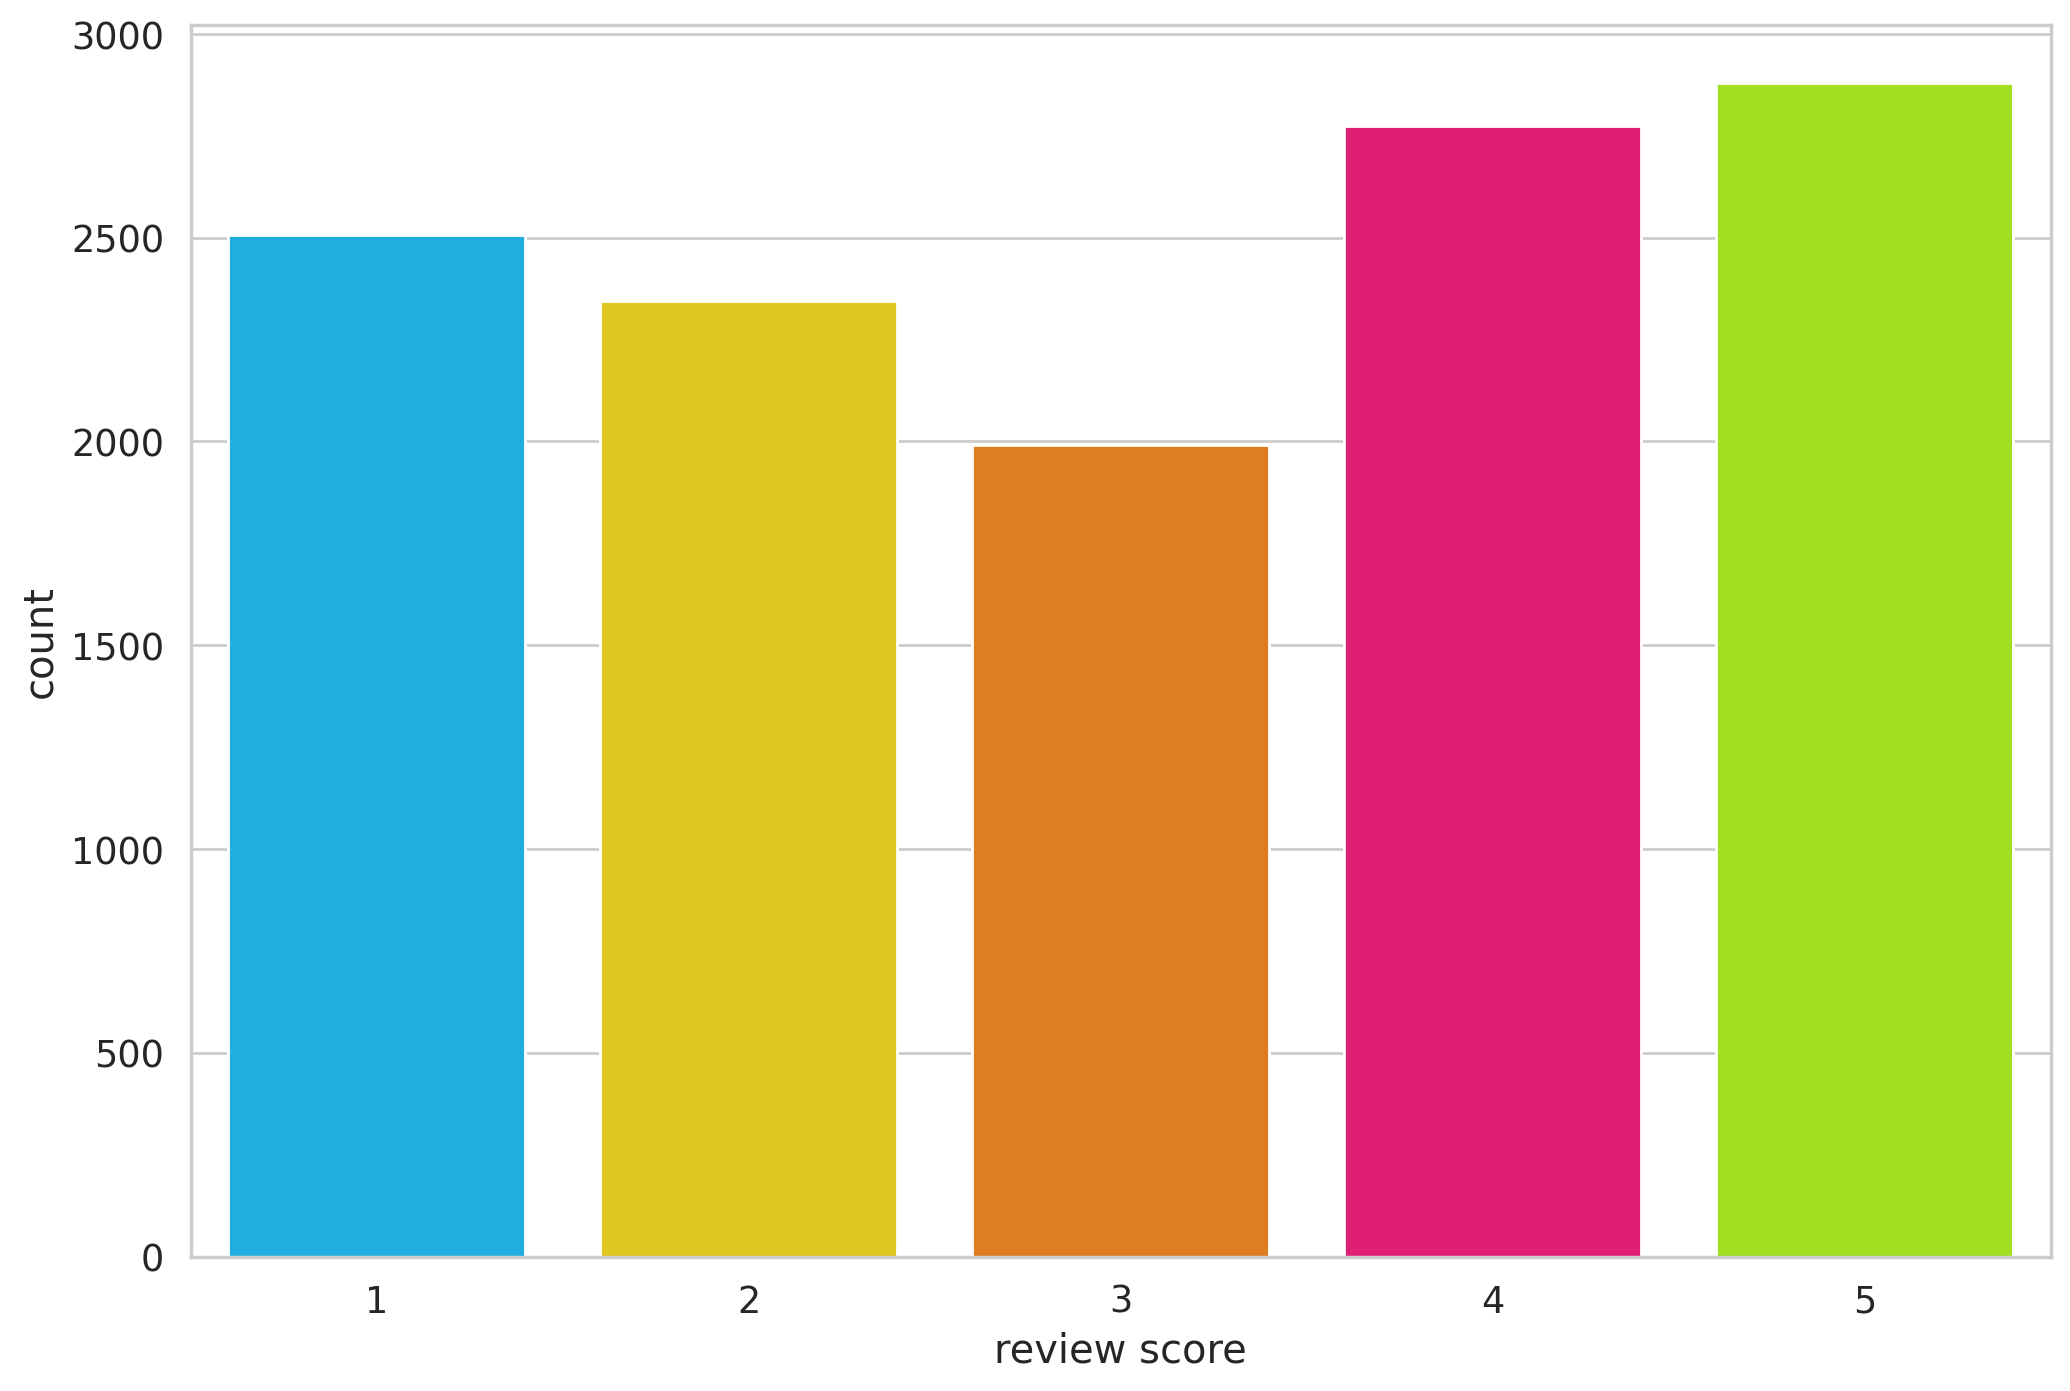

In [9]:
print(df.score.value_counts())
sns.countplot(df, x="score")
plt.xlabel('review score');

We're going to convert the dataset into negative, neutral and positive sentiment:

In [10]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [11]:
class_names = ['negative', 'neutral', 'positive']

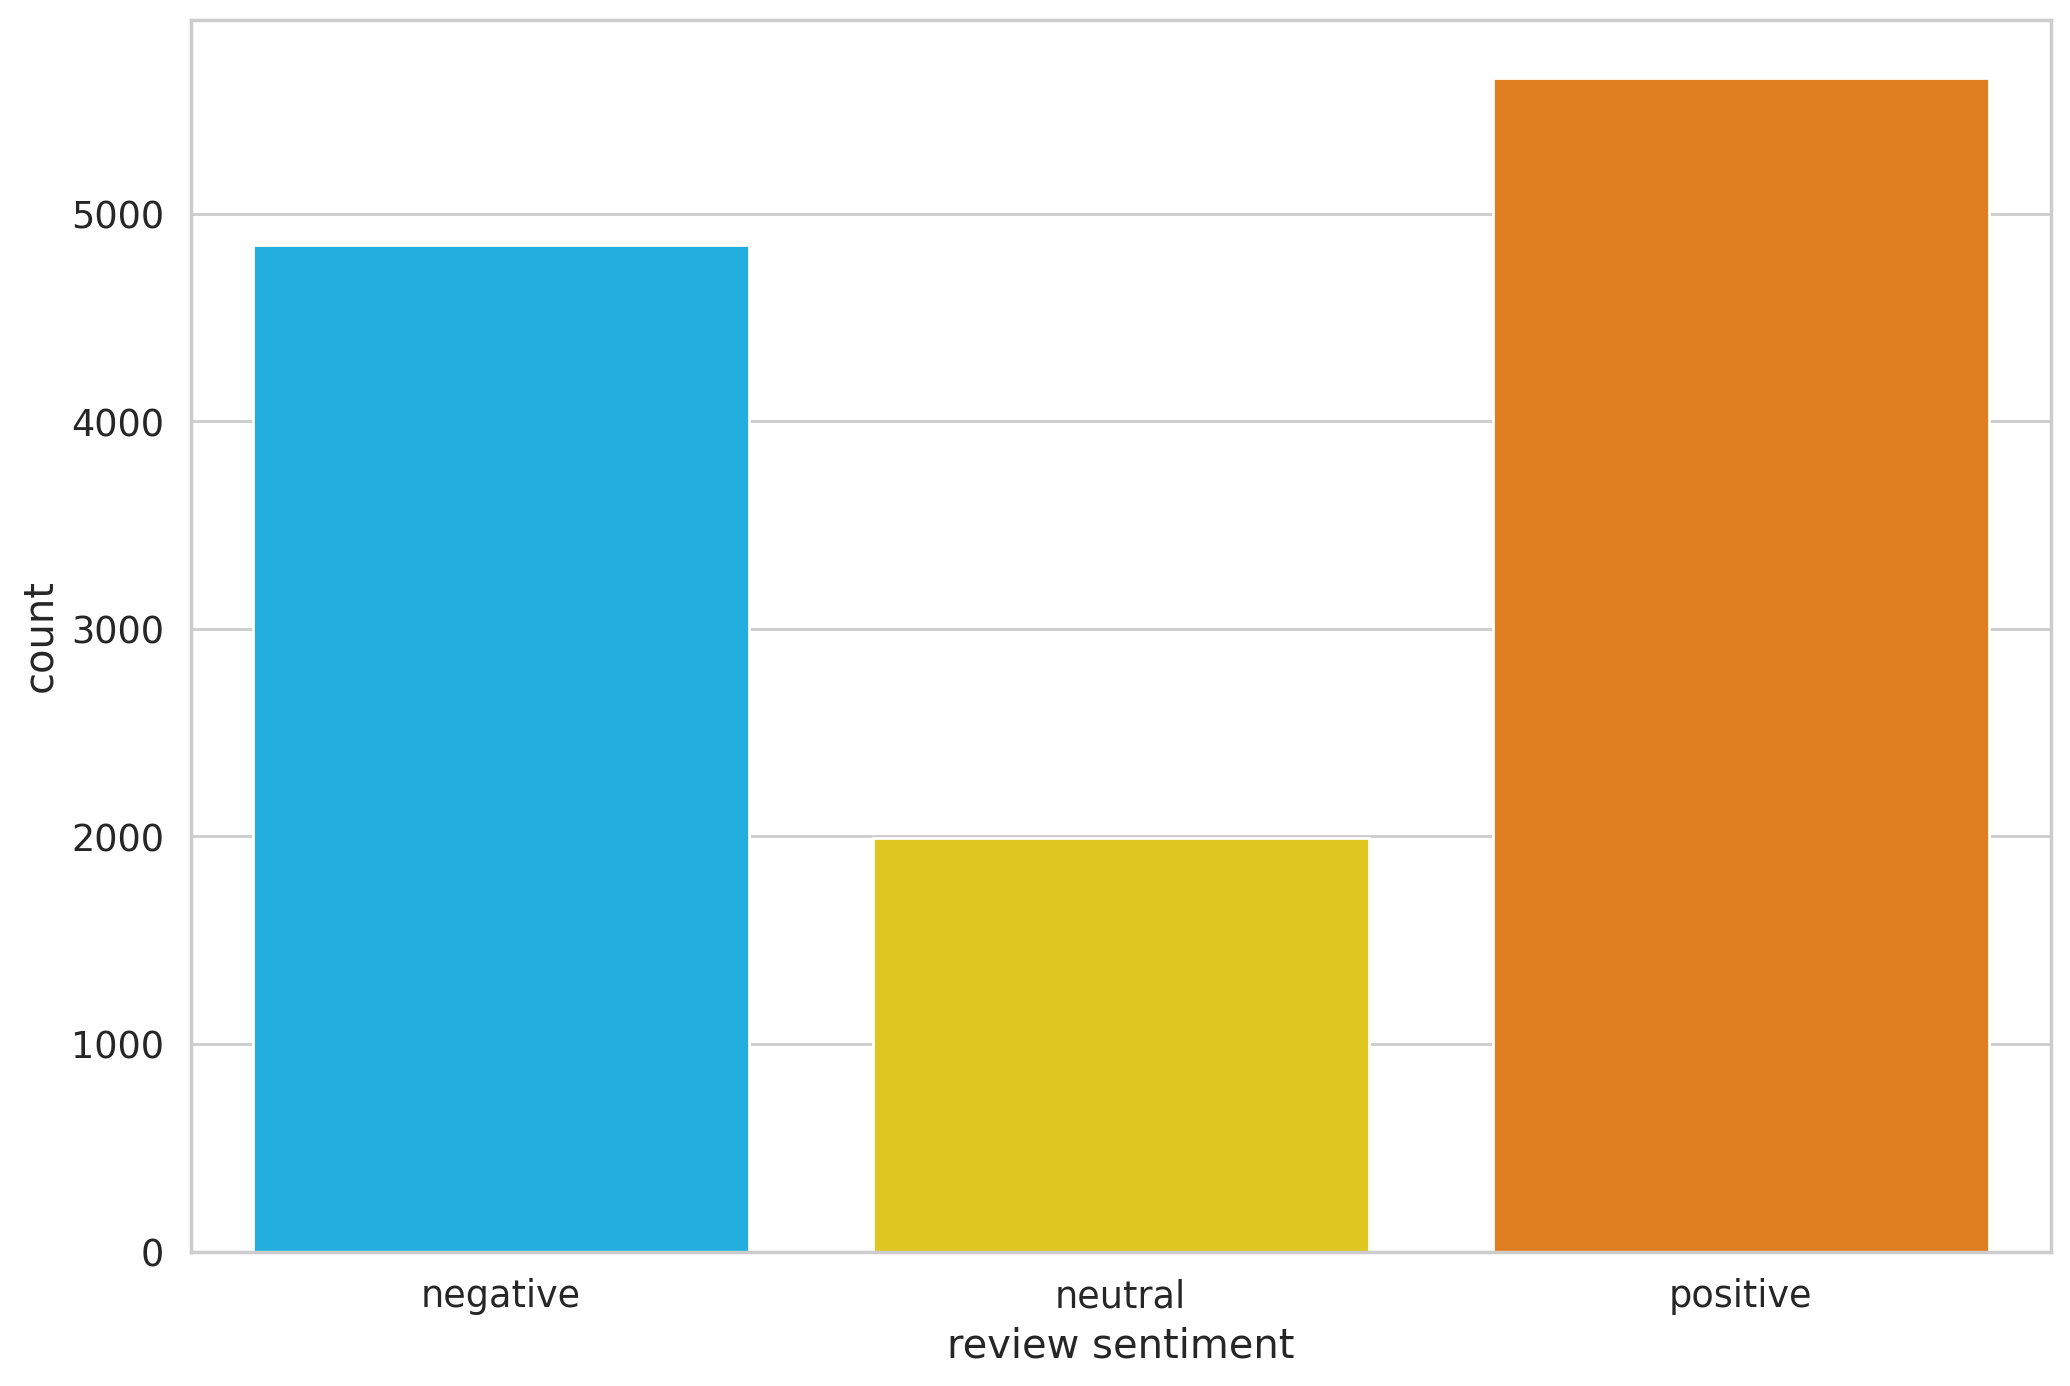

In [15]:
ax = sns.countplot(df, x='sentiment')
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention. Here are the requirements:

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides a wide variety of Transformer models (including BERT).

In [16]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

You can use a cased and uncased version of BERT and tokenizer. In this task, the cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [17]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this text to understand the tokenization process:

In [18]:
sample_txt = 'Nice to meet you. How are you?'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [19]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Nice to meet you. How are you?
   Tokens: ['Nice', 'to', 'meet', 'you', '.', 'How', 'are', 'you', '?']
Token IDs: [8835, 1106, 2283, 1128, 119, 1731, 1132, 1128, 136]


### Special Tokens

`[SEP]` - marker for ending of a sentence

In [20]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

[CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [21]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [22]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [23]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [24]:
encoding = tokenizer.encode_plus(
  sample_txt,
  truncation = True,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()
# trucation=True

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [25]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 8835, 1106, 2283, 1128,  119, 1731, 1132, 1128,  136,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [26]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask'][0]

32


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

We can inverse the tokenization to have a look at the special tokens:

In [27]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Nice',
 'to',
 'meet',
 'you',
 '.',
 'How',
 'are',
 'you',
 '?',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [28]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, truncation = True, max_length=512)
  token_lens.append(len(tokens))

In [29]:
tokens;

and plot the distribution:

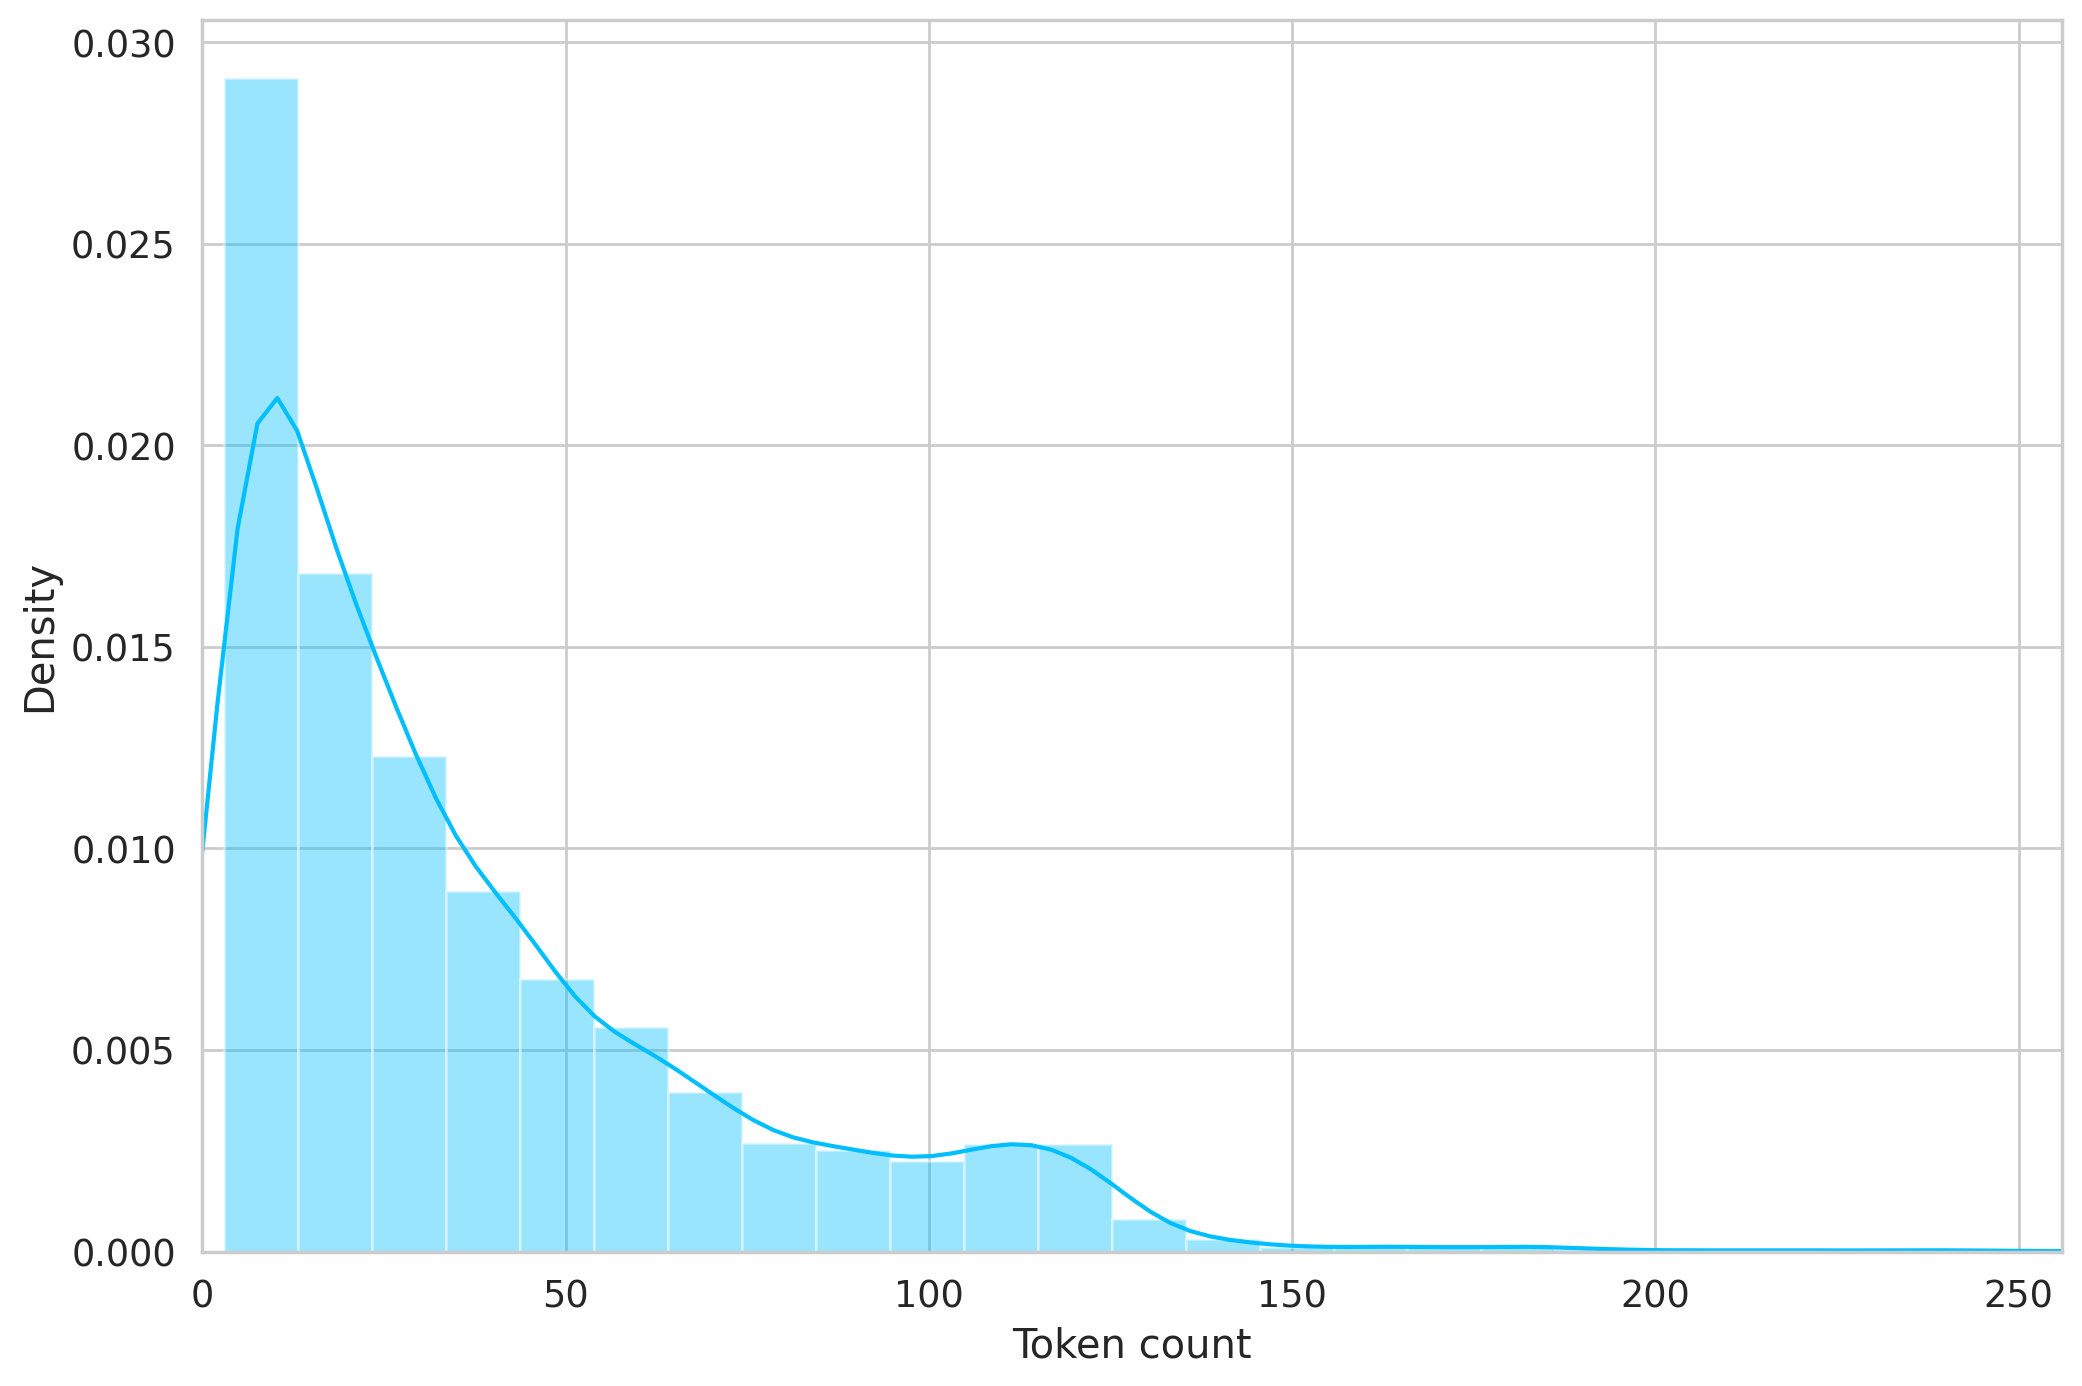

In [30]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [31]:
MAX_LEN = 160

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [32]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),               # flatten(): [1, 160] -> [160]
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [33]:
### For your understanding
ds = GPReviewDataset(
reviews=df.content.to_numpy(),        # df.content.to_numpy().shape: (15746,)
targets=df.sentiment.to_numpy(),      # df.sentiment.to_numpy().shape: (15746,)
tokenizer=tokenizer,
max_len=160
)

In [34]:
ds.__len__()

12495

In [35]:
ds.__getitem__(0)['review_text']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


'I cannot open the app anymore'

In [36]:
ds.__getitem__(0)['input_ids']    # size(): [160]

tensor([  101,   146,  2834,  1501,  1103, 12647,  4169,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [37]:
ds.__getitem__(0)['attention_mask']    # size(): [160]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Let's split the dataset:

In [38]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [39]:
df_train.shape, df_val.shape, df_test.shape

((11245, 13), (625, 13), (625, 13))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [40]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),        # df.content.to_numpy().shape: (15746,)
    targets=df.sentiment.to_numpy(),      # df.sentiment.to_numpy().shape: (15746,)
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [41]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [42]:
sample_batched = next(iter(train_data_loader))
sample_batched.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [43]:
print(sample_batched['input_ids'].shape)
print(sample_batched['attention_mask'].shape)
print(sample_batched['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else.

We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [44]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And try to use it on the encoding of our sample text:

In [45]:
last_hidden_state, pooled_output = bert_model(               # pooled_output: last_hidden_state's first token([CLS]) -> nn.Linear(config.hidden_size, config.hidden_size) -> nn.Tanh()
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  return_dict=False
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [46]:
last_hidden_state.size()

torch.Size([1, 32, 768])

In [47]:
pooled_output.size()

torch.Size([1, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [48]:
bert_model.config.hidden_size

768

You can think of the `pooled_output` as a summary of the content, according to BERT.
So, we'll use `pooled_output` for the sentiment analysis.

We can use all of this knowledge to create a classifier that uses the BERT model:

In [49]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [50]:
model = SentimentClassifier(len(class_names))       # len(class_names): 3
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [51]:
input_ids = sample_batched['input_ids'].to(device)
attention_mask = sample_batched['attention_mask'].to(device)

print(input_ids.size()) # (batch size, seq length)
print(attention_mask.size()) # (batch size, seq length)

torch.Size([16, 160])
torch.Size([16, 160])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [52]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2436, 0.4429, 0.3134],
        [0.2343, 0.3055, 0.4602],
        [0.3186, 0.2772, 0.4043],
        [0.2116, 0.3883, 0.4001],
        [0.5837, 0.2058, 0.2104],
        [0.2549, 0.3533, 0.3918],
        [0.2507, 0.3553, 0.3940],
        [0.3946, 0.2217, 0.3837],
        [0.3583, 0.1887, 0.4531],
        [0.3503, 0.1905, 0.4592],
        [0.3067, 0.2542, 0.4391],
        [0.3532, 0.1884, 0.4583],
        [0.2181, 0.3887, 0.3932],
        [0.2915, 0.2935, 0.4150],
        [0.3718, 0.2572, 0.3710],
        [0.1536, 0.3150, 0.5314]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

################################# **Doing yourself from here **#################################

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [53]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest.

Let's continue with writing a helper function for training our model for one epoch:

In [54]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):

  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [55]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

We can look at the training vs validation accuracy:

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? download my trained model:

In [ ]:
!wget https://www.dropbox.com/s/g82n1d3gl0qfycn/best_model_state.bin

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

### Evaluation

Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

Looks like it is hard to classify neutral (3 stars) reviews.
We'll continue with the confusion matrix:

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "well, not bad"

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

# References
- [Training a causal language model from scratch](https://huggingface.co/learn/nlp-course/chapter7/6)
- [Causal language modeling](https://huggingface.co/docs/transformers/tasks/language_modeling)
- [Sentiment Analysis with BERT and Transformers by Hugging Face using PyTorch and Python](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)
- [BERT implementation](https://github.com/codertimo/BERT-pytorch)